# Task 5: Strategy Backtesting

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# load data
plt.rcParams["figure.figsize"] = (11,4)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

# Find prices.csv from Task-1
CANDIDATE_DIRS = ["/content/drive/MyDrive/preprocessed_data"]
def find_file(name):
    for d in CANDIDATE_DIRS:
        p = os.path.join(d, name)
        if os.path.exists(p): return p
    raise FileNotFoundError(f"Could not find {name} under {CANDIDATE_DIRS}")

prices_path = find_file("prices.csv")
close = pd.read_csv(prices_path, parse_dates=["Date"]).set_index("Date").sort_index()
close = close[["TSLA","BND","SPY"]].astype(float)

print("Loaded:", prices_path)
print("Window:", close.index.min().date(), "→", close.index.max().date(), "rows:", len(close))
display(close.tail(3))


Loaded: /content/drive/MyDrive/preprocessed_data/prices.csv
Window: 2015-07-01 → 2025-07-31 rows: 2632


,TSLA,BND,SPY
Date,,,
2025-07-29,321.200000,73.380000,635.260000
2025-07-30,319.040000,73.190000,634.460000
2025-07-31,308.270000,73.200000,632.080000


# Define backtest window & daily returns

In [5]:
BT_START = pd.Timestamp("2024-08-01")
BT_END   = pd.Timestamp("2025-07-31")
assert close.index.min() <= BT_START < BT_END <= close.index.max()

prices_bt = close.loc[BT_START:BT_END]
rets_bt = prices_bt.pct_change().dropna()

print("Backtest window:", prices_bt.index.min().date(), "→", prices_bt.index.max().date(), "days:", len(prices_bt))
display(rets_bt.head())


Backtest window: 2024-08-01 → 2025-07-31 days: 261


,TSLA,BND,SPY
Date,,,
2024-08-02,-0.042378,0.011418,-0.018620
2024-08-05,-0.042327,-0.000941,-0.029123
2024-08-06,0.008850,-0.006188,0.009219
2024-08-07,-0.044258,-0.002436,-0.006683
2024-08-08,0.036921,-0.001493,0.023118


# Portfolios (strategy vs benchmark)

In [6]:
# Strategy weights from Task-4 (Max Sharpe)
w_strategy = pd.Series({"TSLA": 0.0, "BND": 0.1799, "SPY": 0.8201})
w_strategy = w_strategy.loc[["TSLA","BND","SPY"]]
w_strategy = w_strategy / w_strategy.sum()  # safety normalize

# Benchmark: 60% SPY / 40% BND (static)
w_bench = pd.Series({"TSLA": 0.0, "BND": 0.40, "SPY": 0.60})
w_bench = w_bench.loc[["TSLA","BND","SPY"]]
print("Strategy weights\n", w_strategy.round(4))
print("\nBenchmark weights\n", w_bench.round(4))

Strategy weights
 TSLA   0.000000
BND    0.179900
SPY    0.820100
dtype: float64

Benchmark weights
 TSLA   0.000000
BND    0.400000
SPY    0.600000
dtype: float64


# Simulators (buy-and-hold vs monthly rebalance)

In [7]:
def simulate_hold(returns: pd.DataFrame, weights: pd.Series, initial=1.0) -> pd.Series:
    """
    Buy-and-hold: split initial capital by weights, let each leg grow by its own cumulative return.
    """
    growth = (1 + returns).cumprod()
    value = (growth * weights).sum(axis=1) * initial
    return value

def simulate_monthly_rebalance(returns: pd.DataFrame, weights: pd.Series, initial=1.0) -> pd.Series:
    """
    Rebalance to target weights at the start of each month (first trading day of month).
    """
    value = initial
    values = []
    current_weights = weights.copy()
    last_month = returns.index[0].month

    for dt, row in returns.iterrows():
        # daily portfolio return = w · r
        value *= (1.0 + float(np.dot(current_weights.values, row.values)))
        values.append((dt, value))

        # if month changed, rebalance for next day
        if dt.month != last_month:
            current_weights = weights.copy()
            last_month = dt.month
        else:
            # drift weights: w_i,new ∝ w_i,old * (1+r_i)
            growth = (1.0 + row.values)
            alloc = current_weights.values * growth
            if alloc.sum() > 0:
                current_weights = pd.Series(alloc/alloc.sum(), index=weights.index)
    return pd.Series(dict(values))


# Run simulations & compute metrics

In [8]:
FREQ = 252  # trading days/year

def perf_from_value(value: pd.Series):
    daily_ret = value.pct_change().dropna()
    tot_ret = value.iloc[-1] / value.iloc[0] - 1.0
    ann_ret = (1.0 + tot_ret)**(FREQ/len(value)) - 1.0
    ann_vol = daily_ret.std() * np.sqrt(FREQ)
    sharpe  = daily_ret.mean() / daily_ret.std() * np.sqrt(FREQ) if daily_ret.std()>0 else np.nan
    return {"TotalReturn": tot_ret, "AnnReturn": ann_ret, "AnnVol": ann_vol, "Sharpe": sharpe}

# Strategy
val_strat_hold = simulate_hold(rets_bt, w_strategy, initial=1.0)
val_strat_mo   = simulate_monthly_rebalance(rets_bt, w_strategy, initial=1.0)

# Benchmark (buy-and-hold is the usual interpretation of 60/40)
val_bench_hold = simulate_hold(rets_bt, w_bench, initial=1.0)

m_strat_hold = perf_from_value(val_strat_hold)
m_strat_mo   = perf_from_value(val_strat_mo)
m_bench      = perf_from_value(val_bench_hold)

print("Strategy (Hold) :", {k: round(v,4) for k,v in m_strat_hold.items()})
print("Strategy (Monthly):", {k: round(v,4) for k,v in m_strat_mo.items()})
print("Benchmark (60/40):", {k: round(v,4) for k,v in m_bench.items()})


Strategy (Hold) : {'TotalReturn': np.float64(0.158), 'AnnReturn': np.float64(0.1527), 'AnnVol': np.float64(0.1633), 'Sharpe': np.float64(0.955)}
Strategy (Monthly): {'TotalReturn': np.float64(0.1568), 'AnnReturn': np.float64(0.1517), 'AnnVol': np.float64(0.1618), 'Sharpe': np.float64(0.9565)}
Benchmark (60/40): {'TotalReturn': np.float64(0.1104), 'AnnReturn': np.float64(0.1068), 'AnnVol': np.float64(0.1225), 'Sharpe': np.float64(0.8924)}


# Plot cumulative value (strategy vs benchmark)

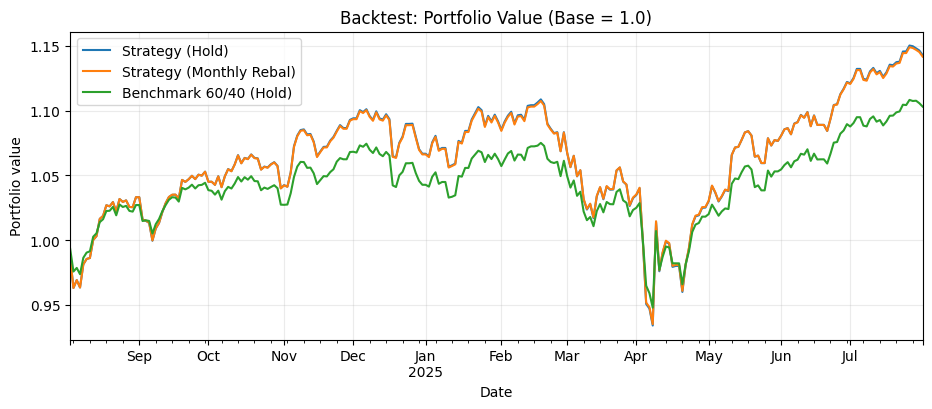

In [9]:
import matplotlib.dates as mdates

plt.figure(figsize=(11,4))
(val_strat_hold).plot(label="Strategy (Hold)")
(val_strat_mo).plot(label="Strategy (Monthly Rebal)")
(val_bench_hold).plot(label="Benchmark 60/40 (Hold)")
plt.title("Backtest: Portfolio Value (Base = 1.0)")
plt.ylabel("Portfolio value")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()


# save

In [10]:
SAVE = False  # flip to True if you want files
if SAVE:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    outdir = "/content/drive/MyDrive/preprocessed_data"
    os.makedirs(outdir, exist_ok=True)
    val_strat_hold.to_csv(os.path.join(outdir, "bt_strategy_hold.csv"))
    val_strat_mo.to_csv(os.path.join(outdir, "bt_strategy_monthly.csv"))
    val_bench_hold.to_csv(os.path.join(outdir, "bt_benchmark_60_40.csv"))
    print("Saved CSVs →", outdir)
